# Análisis propiedades

## EDA muy preliminar

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import *
plt.style.use('ggplot')
from sortedcontainers import SortedList
import copy
import collections
from itertools import product,chain
from sklearn.model_selection import KFold

In [2]:
train=pd.read_csv('train.csv',encoding='latin')
test=pd.read_csv('test.csv',encoding='latin')

In [3]:
train.columns

Index(['Id', 'pais', 'provincia_departamento', 'ciudad', 'property_type',
       'operation_type', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'currency', 'price'],
      dtype='object')

In [4]:
test.columns

Index(['Id', 'pais', 'provincia_departamento', 'ciudad', 'property_type',
       'operation_type', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'currency'],
      dtype='object')

In [5]:
train.head()

Id       pais provincia_departamento        ciudad property_type  \
0   0  Argentina        Capital Federal  Villa Crespo  Departamento   
1   1  Argentina        Capital Federal       Palermo  Departamento   
2   2   Colombia             AtlÃ¡ntico  Barranquilla   Apartamento   
3   3   Colombia        Valle del Cauca          Cali   Apartamento   
4   4  Argentina        Capital Federal     Balvanera  Departamento   

  operation_type  rooms  bedrooms  bathrooms  surface_total currency  \
0          Venta    2.0       1.0        1.0           37.0      USD   
1          Venta    6.0       4.0        4.0          300.0      USD   
2          Venta    3.0       3.0        3.0           95.0      USD   
3          Venta    3.0       3.0        1.0           60.0      USD   
4          Venta    3.0       2.0        1.0           45.0      USD   

       price  
0    85000.0  
1  1590000.0  
2    85329.0  
3    22846.0  
4    80000.0

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25660 entries, 0 to 25659
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      25660 non-null  int64  
 1   pais                    25660 non-null  object 
 2   provincia_departamento  25660 non-null  object 
 3   ciudad                  25660 non-null  object 
 4   property_type           25660 non-null  object 
 5   operation_type          25660 non-null  object 
 6   rooms                   25660 non-null  float64
 7   bedrooms                25660 non-null  float64
 8   bathrooms               25660 non-null  float64
 9   surface_total           25660 non-null  float64
 10  currency                25660 non-null  object 
 11  price                   25660 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 2.3+ MB


Afortunadamene no tenemos valores nulos.

In [7]:
train.describe()

Id         rooms      bedrooms     bathrooms  surface_total  \
count  25660.00000  25660.000000  25660.000000  25660.000000   25660.000000   
mean   12829.50000      2.648207      1.989751      1.682502      78.966875   
std     7407.54829      1.022895      0.937260      0.895758      53.229903   
min        0.00000      1.000000      1.000000      1.000000      10.000000   
25%     6414.75000      2.000000      1.000000      1.000000      43.000000   
50%    12829.50000      3.000000      2.000000      1.000000      63.000000   
75%    19244.25000      3.000000      3.000000      2.000000      94.000000   
max    25659.00000     12.000000      7.000000      6.000000     347.000000   

              price  
count  2.566000e+04  
mean   1.656802e+05  
std    2.244543e+05  
min    6.009000e+03  
25%    7.100000e+04  
50%    1.050000e+05  
75%    1.700000e+05  
max    3.450000e+06

¿Qué variables no debiesen ser consideradas?

In [8]:
for col in train.select_dtypes(exclude=['int64','float64']):
    print('************************')
    print('Columna:'+col)
    print(train[col].value_counts())
    print('************************')

************************
Columna:pais
Argentina    16892
Colombia      8768
Name: pais, dtype: int64
************************
************************
Columna:provincia_departamento
Capital Federal                  8998
Cundinamarca                     3376
Buenos Aires Costa AtlÃ¡ntica    1964
Santa Fe                         1919
Valle del Cauca                  1762
Antioquia                        1736
Bs.As. G.B.A. Zona Norte         1510
AtlÃ¡ntico                       1456
Bs.As. G.B.A. Zona Sur            795
Bs.As. G.B.A. Zona Oeste          657
CÃ³rdoba                          458
NeuquÃ©n                          183
Buenos Aires Interior             175
Risaralda                         151
RÃ­o Negro                        104
Santander                         102
Mendoza                            74
BolÃ­var                           43
QuindÃ­o                           41
Norte de Santander                 33
Magdalena                          33
Tolima              

Vamos a excluir las columnas ```operation_type``` ya que siempre hay una venta, ```property_type``` pues se usan _Departamento_ y _Apartamento_ en cada país y ```currency``` que no aportan valor.

In [9]:
train=train.drop(columns=['operation_type','property_type','currency'])
test=test.drop(columns=['operation_type','property_type','currency'])

In [10]:
train.columns

Index(['Id', 'pais', 'provincia_departamento', 'ciudad', 'rooms', 'bedrooms',
       'bathrooms', 'surface_total', 'price'],
      dtype='object')

In [11]:
cols_plot=train.columns[2:]

Vamos a hacer una breve inspección visual de lo que hay como dato.

In [12]:
?sns.violinplot

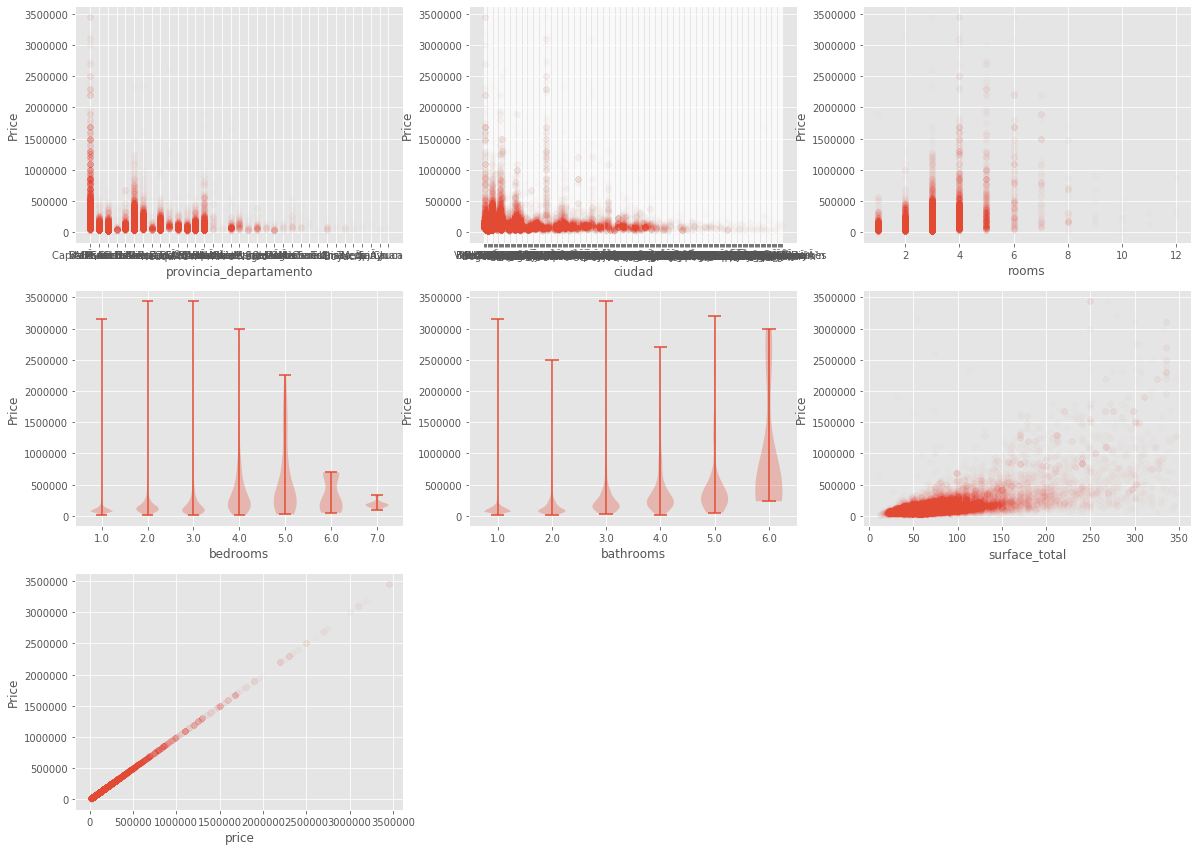

In [13]:
plt.figure(figsize=(20,20))

for i, feature in enumerate(cols_plot):
    plt.subplot(4, 3, i+1)
    col_values = train[feature]
    unique = sorted(set(col_values.dropna().values))
    if len(unique) < 10:
        # categorical: let's make a violin plot
        plt.violinplot([train.price.values[col_values == level] for level in unique],
                       positions=range(len(unique)))
        plt.xticks(range(len(unique)), labels=unique)
    else:
        plt.scatter(col_values.values,train.price.values, alpha=0.01, edgecolor=None)
    plt.xlabel(feature)
    plt.ylabel('Price')
    

Usando los datos tal como están, se daría una oportunidad de mejora

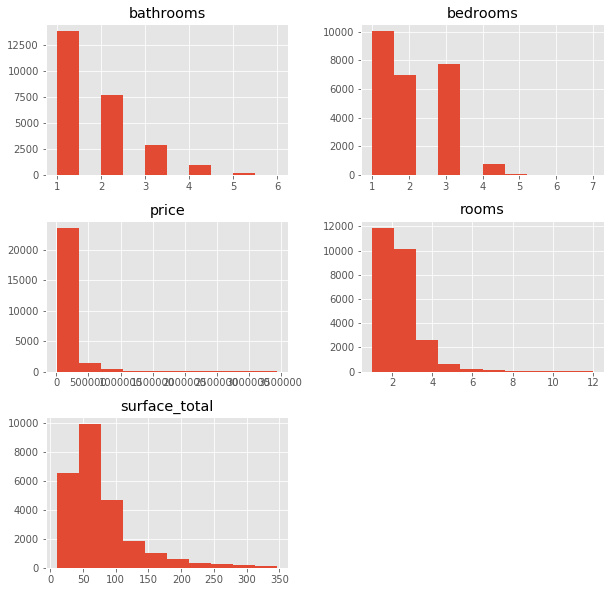

In [14]:
train.iloc[:,1:].hist(figsize=(10,10));

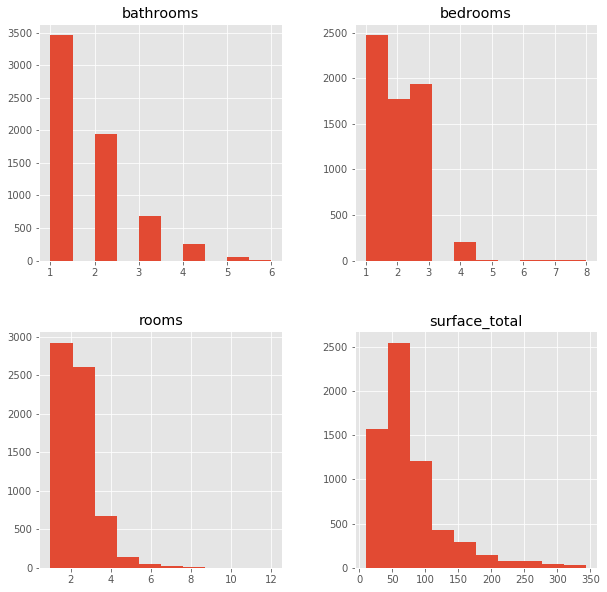

In [15]:
test.iloc[:,1:].hist(figsize=(10,10));

Hay asimetrías en la distribución de varias variables, particularmente fuerte en ```price``` y ```surface_total```. Vamos a verificar si eventualmente conviene filtrar por _outliers_.

In [16]:
def en_rango(serie):
    Q1,Q3=serie.quantile([0.25,0.75])
    IQR=Q3-Q1
    techo=Q3+2.5*IQR
    piso=max(0,Q1-2.5*IQR)
    return (serie<techo) & (serie>piso)

¿Tiene sentido creer que podemos pensar en solo única dinámica de precios para países distintos?

In [17]:
train_arg=train[train.pais=='Argentina']
train_col=train[train.pais=='Colombia']

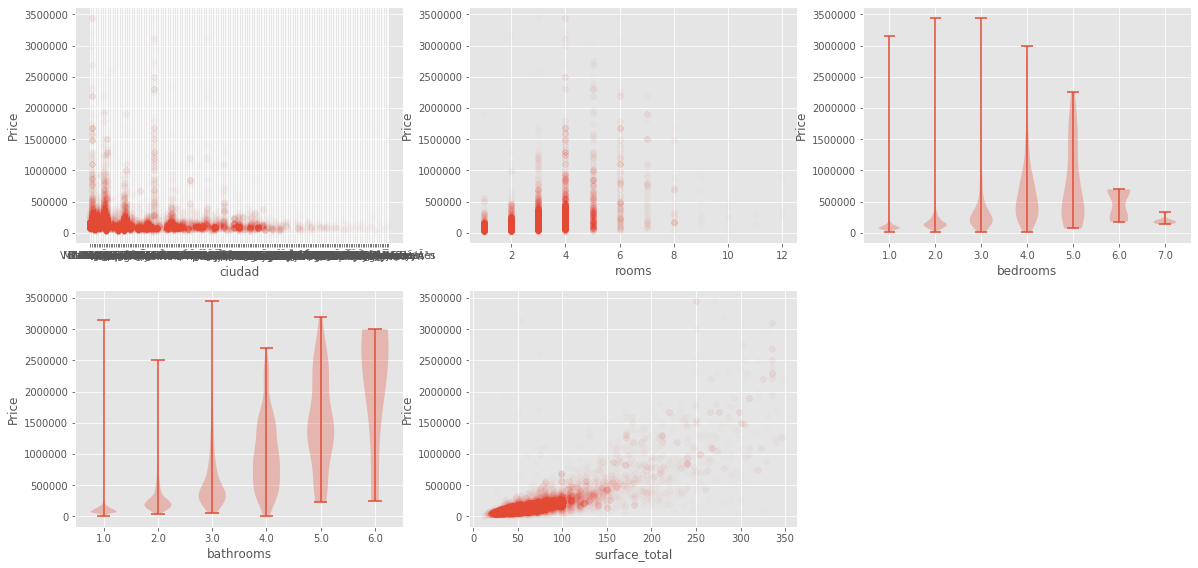

In [18]:
plt.figure(figsize=(20,20))

for i, feature in enumerate(cols_plot[1:-1]):
    plt.subplot(4, 3, i+1)
    col_values = train_arg[feature]
    unique = sorted(set(col_values.dropna().values))
    if len(unique) < 10:
        # categorical: let's make a violin plot
        plt.violinplot([train_arg.price.values[col_values == level] for level in unique],
                       positions=range(len(unique)))
        plt.xticks(range(len(unique)), labels=unique)
    else:
        plt.scatter(col_values.values,train_arg.price.values, alpha=0.01, edgecolor=None)
    plt.xlabel(feature)
    plt.ylabel('Price')

In [19]:
plt.figure(figsize=(20,20))

for i, feature in enumerate(cols_plot[1:-1]):
    plt.subplot(4, 3, i+1)
    col_values = train_col[feature]
    unique = sorted(set(col_values.dropna().values))
    if len(unique) < 10:
        # categorical: let's make a violin plot
        plt.violinplot([train_col.price.values[col_values == level] for level in unique],
                       positions=range(len(unique)))
        plt.xticks(range(len(unique)), labels=unique)
    else:
        plt.scatter(col_values.values,train_col.price.values, alpha=0.01, edgecolor=None)
    plt.xlabel(feature)
    plt.ylabel('Price')

Hay que notar que la variablidad para cada tramo de precio y variable parece ser distinta. Para hacer más fácil la lectura, hare histogramas por país.

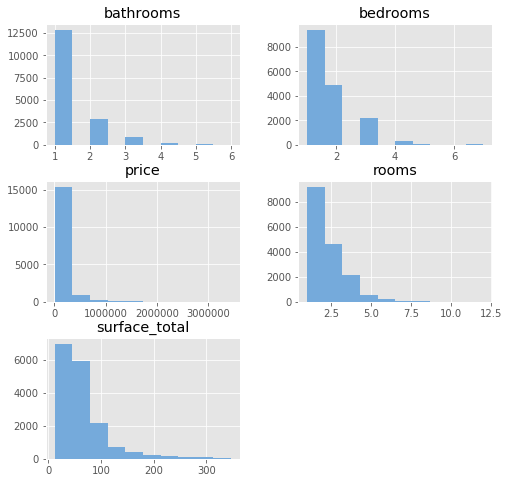

In [20]:
train_arg.iloc[:,2:].hist(figsize=(8,8), color='#75AADB');

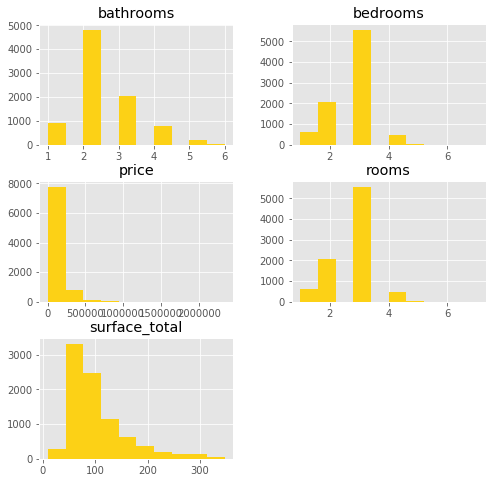

In [21]:
train_col.iloc[:,2:].hist(figsize=(8,8), color='#FCD116');

Dada la fuerte asimetría, Voy a usar la transformación de Box-Cox para ver si hay alguna mejora.

In [22]:
from scipy import stats
trains=[train_arg,train_col]
columnas=['surface_total','price']
fitted_lambdas=[]

for t in trains:
    for columna in columnas:
        y, fitted_lambda = stats.boxcox(t[columna])
        fitted_lambdas.append(fitted_lambda)
        t[columna]=y

/Users/ggoni/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [23]:
fitted_lambdas

[-0.5866245649980928,
 -0.41576726371403894,
 -0.3674595194695659,
 -0.24687443449365915]

In [24]:
lambda_sur_arg=fitted_lambdas[0]
lambda_price_arg=fitted_lambdas[1]
lambda_sur_col=fitted_lambdas[2]
lambda_price_col=fitted_lambdas[3]

In [25]:
X_train_arg=train_arg.iloc[:,2:-1]
y_train_arg=train_arg.iloc[:,-1]

In [26]:
train_col.head()

Id      pais provincia_departamento         ciudad  rooms  bedrooms  \
2    2  Colombia             AtlÃ¡ntico   Barranquilla    3.0       3.0   
3    3  Colombia        Valle del Cauca           Cali    3.0       3.0   
5    5  Colombia              Santander  Floridablanca    3.0       3.0   
8    8  Colombia           Cundinamarca    BogotÃ¡ D.C    3.0       3.0   
12  12  Colombia              Risaralda        Pereira    3.0       3.0   

    bathrooms  surface_total     price  
2         3.0       2.210816  3.805080  
3         1.0       2.116894  3.710669  
5         2.0       2.164483  3.783384  
8         2.0       2.206808  3.822817  
12        3.0       2.254244  3.812328

In [27]:
from catboost import CatBoostRegressor

In [28]:
X_train_arg.head()

provincia_departamento        ciudad  rooms  bedrooms  bathrooms  \
0         Capital Federal  Villa Crespo    2.0       1.0        1.0   
1         Capital Federal       Palermo    6.0       4.0        4.0   
4         Capital Federal     Balvanera    3.0       2.0        1.0   
6  Bs.As. G.B.A. Zona Sur      La Plata    3.0       2.0        1.0   
7         Capital Federal  Villa Crespo    4.0       3.0        1.0   

   surface_total  
0       1.499696  
1       1.644620  
4       1.521932  
6       1.580540  
7       1.590277

In [29]:
cb_arg=CatBoostRegressor()

In [30]:
cb_arg.fit(X_train_arg,y_train_arg,cat_features=[0,1],silent=True)

In [31]:
X_train_col=train_col.iloc[:,2:-1]
y_train_col=train_col.iloc[:,-1]

In [32]:
X_train_col.head()

provincia_departamento         ciudad  rooms  bedrooms  bathrooms  \
2              AtlÃ¡ntico   Barranquilla    3.0       3.0        3.0   
3         Valle del Cauca           Cali    3.0       3.0        1.0   
5               Santander  Floridablanca    3.0       3.0        2.0   
8            Cundinamarca    BogotÃ¡ D.C    3.0       3.0        2.0   
12              Risaralda        Pereira    3.0       3.0        3.0   

    surface_total  
2        2.210816  
3        2.116894  
5        2.164483  
8        2.206808  
12       2.254244

In [33]:
cb_col=CatBoostRegressor()

In [79]:
cb_col.fit(X_train_col,y_train_col,cat_features=[0,1],silent=True)

In [35]:
from sklearn.metrics import mean_squared_error

In [36]:
y_pred_train_arg=cb_arg.predict(X_train_arg)

In [37]:
mean_squared_error(y_train_arg,y_pred_train_arg)

4.138405463716632e-06

In [38]:
y_train_arg

0        2.383730
1        2.398841
4        2.383183
6        2.387699
7        2.389278
           ...   
25654    2.398685
25656    2.383730
25657    2.389684
25658    2.386597
25659    2.380884
Name: price, Length: 16892, dtype: float64

In [39]:
y_pred_train_col=cb_col.predict(X_train_col)

In [40]:
mean_squared_error(y_train_col,y_pred_train_col)

0.0002091072043058526

In [41]:
from scipy.special import boxcox, inv_boxcox

In [42]:
X_test_arg=test.loc[test.pais=='Argentina']
X_test_arg['surface_total']=boxcox(X_test_arg['surface_total'],lambda_sur_arg)
X_test_arg.drop(columns=['pais'],inplace=True)

/Users/ggoni/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ggoni/opt/anaconda3/envs/ml/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [43]:
X_test_col=test.loc[test.pais=='Colombia']
X_test_col['surface_total']=boxcox(X_test_col['surface_total'],lambda_sur_col)
X_test_col.drop(columns=['pais'],inplace=True)

/Users/ggoni/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [44]:
y_pred_test_arg=inv_boxcox(cb_arg.predict(X_test_arg.iloc[:,1:]),lambda_price_arg)

In [45]:
y_pred_test_col=inv_boxcox(cb_col.predict(X_test_col.iloc[:,1:]),lambda_price_col)

In [46]:
df_arg=pd.DataFrame(zip(X_test_arg.Id,y_pred_test_arg),columns=['Id','price'])

In [47]:
df_col=pd.DataFrame(zip(X_test_col.Id,y_pred_test_col),columns=['Id','price'])

In [48]:
df_arg

Id          price
0     25660  112352.971515
1     25661  120758.113859
2     25662   76186.193101
3     25664   68725.298243
4     25665  302341.856414
...     ...            ...
4245  32067  142424.636500
4246  32069  228845.657548
4247  32071   78816.251104
4248  32072  133239.831769
4249  32073  198173.743578

[4250 rows x 2 columns]

In [49]:
precios=pd.concat([df_arg,df_col],axis=0)

In [50]:
precios.sort_values(by='Id',inplace=True)

#3era verión del 14 de Julio
precios.to_csv('/Users/ggoni/Desktop/submission.csv',index=False)

## Pendientes

 1. [ ] ¿Valdrá la pena filtrar outliers despues de Box-Cox? 
 2. [ ] ¿Se obtendría mejores resultados haciendo blending de modelos?

In [ ]:
len(en_rango(train_arg.price))-sum(en_rango(train_arg.price))

In [ ]:
len(en_rango(train_col.price))-sum(en_rango(train_col.price))

In [ ]:
train_arg.price.hist()

In [ ]:
cb_arg.save_model('Model_prop_arg.pkl')
cb_col.save_model('Model_prop_col.pkl')

In [ ]:
train_arg.head()

In [ ]:
lambda_price_arg

In [ ]:
lambda_sur_arg

In [ ]:
lambda_price_col

In [ ]:
train.bathrooms.max()

In [ ]:
cb_arg.feature_names_

In [ ]:
cb_arg.predict(['Capital Federal','Palero',6,4,1,1.5])

In [ ]:
import catboost

In [ ]:
cb_arg.save_model('cb_arg')
cb_col.save_model('cb_col')

In [ ]:
cb_arg.feature_importances_

In [ ]:
df_imp=pd.DataFrame(zip(cb_arg.feature_names_,cb_arg.feature_importances_),\
    columns=['Variable','Importancia'])

In [ ]:
df_imp